In [82]:
import functions
from random import sample
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp
import cv2
from scipy.ndimage import convolve1d
from matplotlib.patches import ConnectionPatch
from scipy.ndimage import convolve
from skimage.color import rgb2gray



In [83]:



def projective_fit_model(data):
    """
    data is an iterable of pairs (input, output). Each pair consists of two Euclidean 2d vectors.

    Calculate the projection matrix P that maps all input points onto their corresponding output point,
    or as close as possible.

    data will have at least four pairs. If it has exactly four pairs it should behave the same as
    `projective_transform_matrix` (possibly up to a multiplicative constant):

        projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4) ==
            projective_fit_model([(x1, xa1), (x2, xa2), (x3, xa3), (x4, xa4)])
    """
    M = np.empty((0,9))
    for (x,y), (xa,ya) in data:
        M = np.append(M,
                      np.array([[x, y, 1, 0, 0, 0, -xa*x, -xa*y, -xa],
                                [0, 0, 0, x, y, 1, -ya*x, -ya*y, -ya]]),
                      axis=0)
    _, _, VT = np.linalg.svd(M)
    p = VT[-1]
    P = p.reshape(3,3)
    # YOUR CODE HERE (Replace this and the following line with your code)
    return P


def projective_test_model(P, data, max_error=2):
    """
    Finds indices of inliers in the data for projective transformation
    given by P, where the inliers are determined by the max_error.

    Parameters
    ==========

    P: numpy array
       a 3x3 matrix giving a projective transformation of the plane
    data: list
       each item in data is a tuple (input, output), each consisting
       of a point (numpy array with shape (2,)) in the plane.
    max_error: float
       the maximum Euclidean distance between P(input) and output
       for the pair (input, output) to count as an inlier

    Return Value
    ============
    inliers: numpy array
       the indices of the inliers in data, in order
    """

    index = 0
    inliers = []
    for (x,y), (xa,ya) in data:
      L = e2h(np.array([x,y]))
      [x, y]= h2e(P @ L)
      if np.sqrt((((x - xa)**2))+(((y-ya)**2))) < max_error:
        inliers.append(index)
      index = index + 1
      # plt.scatter(x,y,color="r")
      # plt.scatter(xa,ya,color="b")
    plt.show()
    # YOUR CODE HERE (Replace this and the following line with your code)
    return inliers






def ransac(data, fit_model, test_model, test_model_pars,
           n_model_data, n_iter):
    """
    Use of RANSAC to fit a model to data

    Parameters
    ==========

    data: list
       each item in data is a tuple (input, output)
    fit_model: callable
       a function that takes data (a list of tuples of
       (input, output) pairs) and returns an object describing
       the fitted model
    test_model: callable
       a function that takes as first parameter the model
       (return value of fit_model) and as second argument a list
       of (input, output) tuples (it expects all data tuples
       including those used for the estimation).
       It returns an array with the indices in the list of tuples
       (second parameter) of all data tuples that fit the model
       (i.e. the inliers)
    test_model_pars: dict
       a dictionary that is passed to the ``test_model`` function used to set
       a threshold to determine if an (input, output) pair is an inlier or not.
    n_model_data: int
       the number of data tuples to be used to fit the model
    n_iter: int
       number of iterations


    Return Value
    ============
    (model, inliers): tuple
       model: the model, as returned by fit_model
       inliers: the indices of the inliers of the returned model
           (not just the data points used to fit the model)
    """
    bestone = [0]
    for _ in range(n_iter):
      randomtestdata = sample(data,n_model_data)
      inliers = test_model(fit_model(randomtestdata),data,test_model_pars['max_error'])
      if len(bestone) < len(inliers):
        model = fit_model(randomtestdata)
        bestone = inliers

    return (fit_model([data[i] for i in bestone]), bestone)




def imshow_row(imttllist, axs=False):
    n = len(imttllist)
    for i, imttl in enumerate(imttllist):
        if imttl is None:
            continue
        im, ttl = imttl
        plt.subplot(1,n,i+1)
        plt.imshow(im, cmap='gray')
        if not axs:
            plt.axis('off')
        plt.title(ttl)

def draw_keypoints(kps, nkps=None, ax=None, marker='x',
                   marker_size=10, scale_and_orientation=True):
    if ax is None:
        ax = plt.gca()
    if nkps is None:
        nkps = len(kps)
    xs = [kp.pt[0] for kp in kps]
    ys = [kp.pt[1] for kp in kps]
    ax.scatter(xs, ys, marker=marker)
    if scale_and_orientation:
        for kp in kps[:nkps]:
            x, y = kp.pt
            r = kp.size / 2
            angle = kp.angle/2/np.pi
            ax.add_artist(plt.Circle((kp.pt), kp.size/2,
                                     color='green', fill=False))
            ax.add_artist(plt.Arrow(x, y, r*np.cos(angle),
                                    r*np.sin(angle), color='red'))



def draw_matches(f1, kps1, f2, kps2, matches,
                 horizontal=True, figsize=(15,15)):
    if horizontal:
        fig, axs = plt.subplots(1,2, figsize=figsize)
    else:
        fig, axs = plt.subplots(2,1, figsize=figsize)

    axs[0].imshow(f1)
    axs[1].imshow(f2)

    # get the indexes of the matches
    idx1 = [m.queryIdx for m in matches]
    idx2 = [m.trainIdx for m in matches]

    xs1 = [kps1[i].pt[0] for i in idx1]
    ys1 = [kps1[i].pt[1] for i in idx1]
    xs2 = [kps2[i].pt[0] for i in idx2]
    ys2 = [kps2[i].pt[1] for i in idx2]


    for x1, y1, x2, y2 in zip(xs1, ys1, xs2, ys2):
        con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color='g')
        axs[1].add_artist(con)




def projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4):
    """
    Computes the projective transformation (in homogeneous coordinates) that
    transforms vectors xi into xai. (The vectors are given in Euclidean
    coordinates).
    """
    M = [[x1[0], x1[1], 1,      0,      0,      0,     -xa1[0]*x1[0],    -xa1[0]*x1[1],     -xa1[0]],
         [     0,       0,     0, x1[0], x1[1], 1,     -xa1[1]*x1[0],    -xa1[1]*x1[1],     -xa1[1]],
         [x2[0], x2[1], 1,      0,      0,      0,     -xa2[0]*x2[0],    -xa2[0]*x2[1],     -xa2[0]],
         [     0,       0,     0, x2[0], x2[1], 1,     -xa2[1]*x2[0],    -xa2[1]*x2[1],     -xa2[1]],
         [x3[0], x3[1], 1,      0,      0,      0,     -xa3[0]*x3[0],    -xa3[0]*x3[1],     -xa3[0]],
         [     0,       0,     0, x3[0], x3[1], 1,     -xa3[1]*x3[0],    -xa3[1]*x3[1],     -xa3[1]],
         [x4[0], x4[1], 1,      0,      0,      0,     -xa4[0]*x4[0],    -xa4[0]*x4[1],     -xa4[0]],
         [     0,       0,     0, x4[0], x4[1], 1,     -xa4[1]*x4[0],    -xa4[1]*x4[1],     -xa4[1]],
         ]
    # get the SVD
    U,S,VH = np.linalg.svd(M)

    # transpose
    VH = VH.T

    # take the final column of the V matrix, which corresponds
    #to the smallest eigenvalue
    VH = VH[:,-1]

    # affine matrix
    A = np.array(((VH[0], VH[1],VH[2]),
         (VH[3], VH[4],VH[5]),
         (VH[6], VH[7],VH[8])))/VH[8]

    return A

def projective_transform_image(F, x1, x2, x3, x4, H, W):
    # YOUR CODE HERE (Replace this and the following line with your code)

    xa1 = [0   ,0   ]
    xa2 = [W-1 ,0   ]
    xa3 = [W-1 ,H-1 ]
    xa4 = [0   ,H-1 ]
    print(affine_transform_matrix(x1, x2, x3, xa1, xa2, xa3))

    a = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[0][0]
    b = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[0][1]
    c = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[0][2]
    d = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[1][0]
    e = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[1][1]
    f = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[1][2]
    g = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[2][0]
    h = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[2][1]
    i = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[2][2]

    matrix = [[a, b, c],
              [d, e, f],
              [g, h, i]]
    ll = matrix

    return warp(F, np.array(np.linalg.inv(matrix)),output_shape = (H,W))

def projective_transform_image_matrix(F, x1, x2, x3, x4, H, W):
    # YOUR CODE HERE (Replace this and the following line with your code)

    xa1 = [0   ,0   ]
    xa2 = [W-1 ,0   ]
    xa3 = [W-1 ,H-1 ]
    xa4 = [0   ,H-1 ]
    print(affine_transform_matrix(x1, x2, x3, xa1, xa2, xa3))

    a = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[0][0]
    b = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[0][1]
    c = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[0][2]
    d = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[1][0]
    e = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[1][1]
    f = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[1][2]
    g = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[2][0]
    h = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[2][1]
    i = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)[2][2]

    matrix = [[a, b, c],
              [d, e, f],
              [g, h, i]]
    ll = matrix

    return ll

def affine_transform_matrix(x1, x2, x3, xa1, xa2, xa3):
    """
    Calculates the affine transformation matrix A that maps
    (in homogeneous coordinates) the vectors xi to xai. The
    vectors are given in Euclidean coordinates.
    """
    # YOUR CODE HERE (Replace this and the following line with your code)
    q = np.array([xa1[0],
         xa1[1],
         xa2[0],
         xa2[1],
         xa3[0],
         xa3[1]])
    # print(q)
    M = np.array([[x1[0], x1[1], 1,      0,      0,      0],
         [     0,       0,     0, x1[0], x1[1], 1],
         [x2[0], x2[1], 1,      0,      0,      0],
         [     0,       0,     0, x2[0], x2[1], 1],
         [x3[0], x3[1], 1,      0,      0,      0],
         [     0,       0,     0, x3[0], x3[1], 1]])

    M = np.linalg.inv(M)

    p = np.dot(M, q)

    #return p

    A = np.vstack([[p[0], p[1], p[2]],
                  [p[3], p[4], p[5]],
                  [0, 0, 1]])

    return A
def e2h(x):
    if len(x.shape) == 1:
        return np.hstack((x, [1]))
    return np.vstack((x, np.ones(x.shape[1])))

def h2e(tx):
    return tx[:-1]/tx[-1]


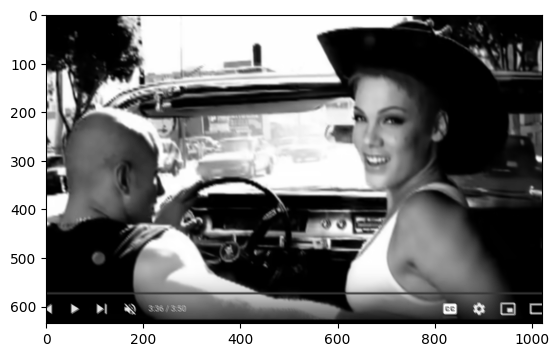

In [84]:
f = plt.imread('jjgfff.png')[:,:,:-1]

f=rgb2gray(f)
plt.imshow
plt.imshow(convolve(f,[
    [0.2,0,0],
    [0,0,0],
    [0,0,0.2]]),cmap='gray')

In [85]:
np.array([1, 0])+np.array([1, 0])

array([2, 0])

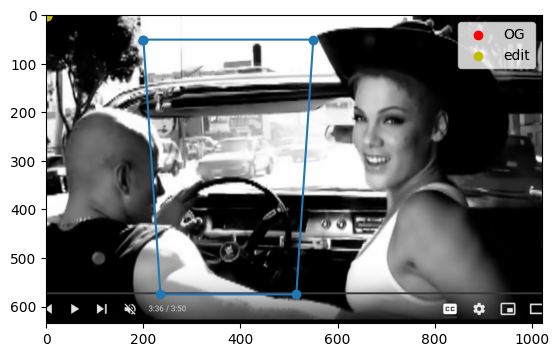

In [86]:
x = [1,1,0,0]
y = [1,0,1,0]

xa=[1,0.8,0,0.2]
ya=[0,1.5,0,1.5]

o=350
x_displace = 200
y_displace = 50
x2 = np.array([1, 0])*o+np.array([x_displace, y_displace])
x3 = np.array([0.9, 1.5])*o+np.array([x_displace, y_displace])
x1 = np.array([0, 0])*o+np.array([x_displace, y_displace])
x4 = np.array([0.1, 1.5])*o+np.array([x_displace, y_displace])

# x1 = np.array([0.6, 0])*o
# x4 = np.array([1, 1.5])*o
# x2 = np.array([0.4, 0])*o
# x3 = np.array([0, 1.5])*o



def quadrilateral(x1, x2, x3, x4):
    return np.column_stack((x1, x2, x3, x4))
def draw_polygon(p, ax, closed=True, filled=False):
    if closed:
        pp = np.column_stack((p,p[:,0]))
    ax.plot(pp[0], pp[1], '-o')

draw_polygon(quadrilateral(x1, x2, x3, x4), ax=plt.gca())

f = plt.imread('jjgfff.png')[:,:,:-1]

f=rgb2gray(f)
plt.imshow(f,cmap='gray')

plt.scatter(x,y,color="r",label="OG")
plt.scatter(xa,ya,color="y",label="edit")
# P = np.array([[-5,1,6],
#      [0,-5,-6],
#      [0,0,-5]])
# data = list(zip(x,y))
# for x,y in data:
#   L = e2h(np.array([x,y]))
#   [xa, ya]= h2e(P @ L)
#   plt.scatter(x,y,color="r",label="OG")
#   plt.scatter(xa,ya,color="y",label="edit")
plt.legend()



[[ 1.71142857e+00  1.14095238e-01 -3.47990476e+02]
 [-2.01606408e-17  1.52190476e+00 -7.60952381e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


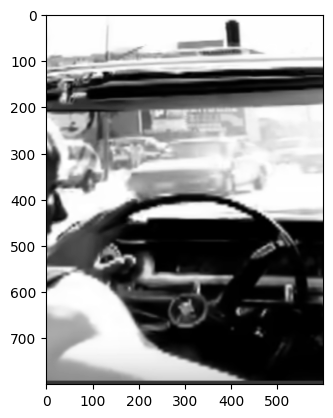

In [87]:
a = np.array(projective_transform_image_matrix(f, x1, x2, x3, x4, 800, 600))
G=warp(f,np.linalg.inv(a),output_shape=(800,600)) 

plt.imshow(G,cmap='gray')

[[ 1.71142857e+00  1.14095238e-01 -3.47990476e+02]
 [-2.01606408e-17  1.52190476e+00 -7.60952381e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
<class 'numpy.ndarray'>


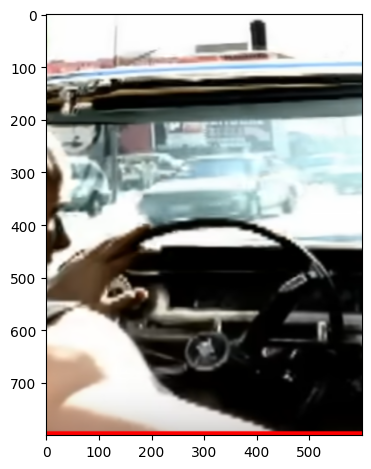

In [88]:
from PIL import Image, ImageDraw
from io import BytesIO
f = plt.imread('jjgfff.png')
G = projective_transform_image(f, x1, x2, x3, x4, 800, 600)
plt.imshow(G)
print(type(G))
plt.tight_layout()


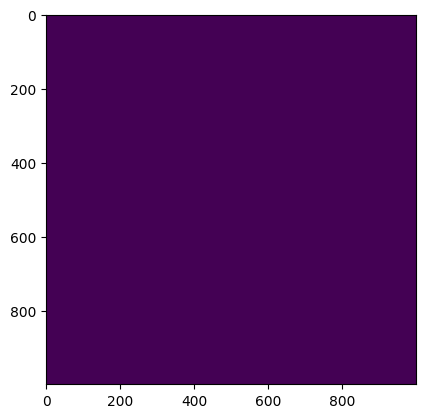

In [89]:
U=np.zeros((1000,1000))
warp
plt.imshow(U)

[[ 1.71142857e+00  1.14095238e-01 -3.47990476e+02]
 [-2.01606408e-17  1.52190476e+00 -7.60952381e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


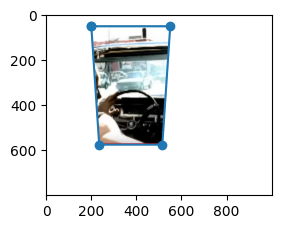

In [90]:

plt.subplot(121)
draw_polygon(quadrilateral(x1, x2, x3, x4), ax=plt.gca())


ll = projective_transform_image_matrix(G, x1, x2, x3, x4, 800, 600)

K = warp(G,np.array(ll),output_shape = (800,1000))
plt.imshow(K);

[[ 1.71142857e+00  0.00000000e+00 -6.84571429e+02]
 [-2.36551519e-16  2.28285714e+00 -1.48385714e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


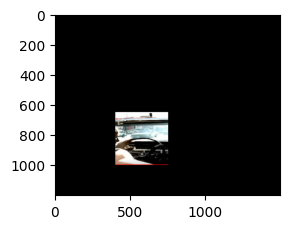

In [91]:
o=350
x_displace = 400
y_displace = 650
x2 = np.array([1, 0])*o+np.array([x_displace, y_displace])
x3 = np.array([1, 1])*o+np.array([x_displace, y_displace])
x1 = np.array([0, 0])*o+np.array([x_displace, y_displace])
x4 = np.array([0, 1])*o+np.array([x_displace, y_displace])
plt.subplot(121)
# draw_polygon(quadrilateral(x1, x2, x3, x4), ax=plt.gca())


ll = projective_transform_image_matrix(G, x1, x2, x3, x4, 800, 600)

K = warp(G,np.array(ll),output_shape = (1200,1500))[:,:,:-1]
plt.imshow(K);


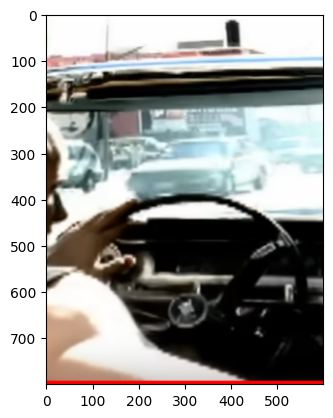

In [92]:
GG = (G[:,:,:-1]*255).astype(np.uint8)
plt.imshow(GG);

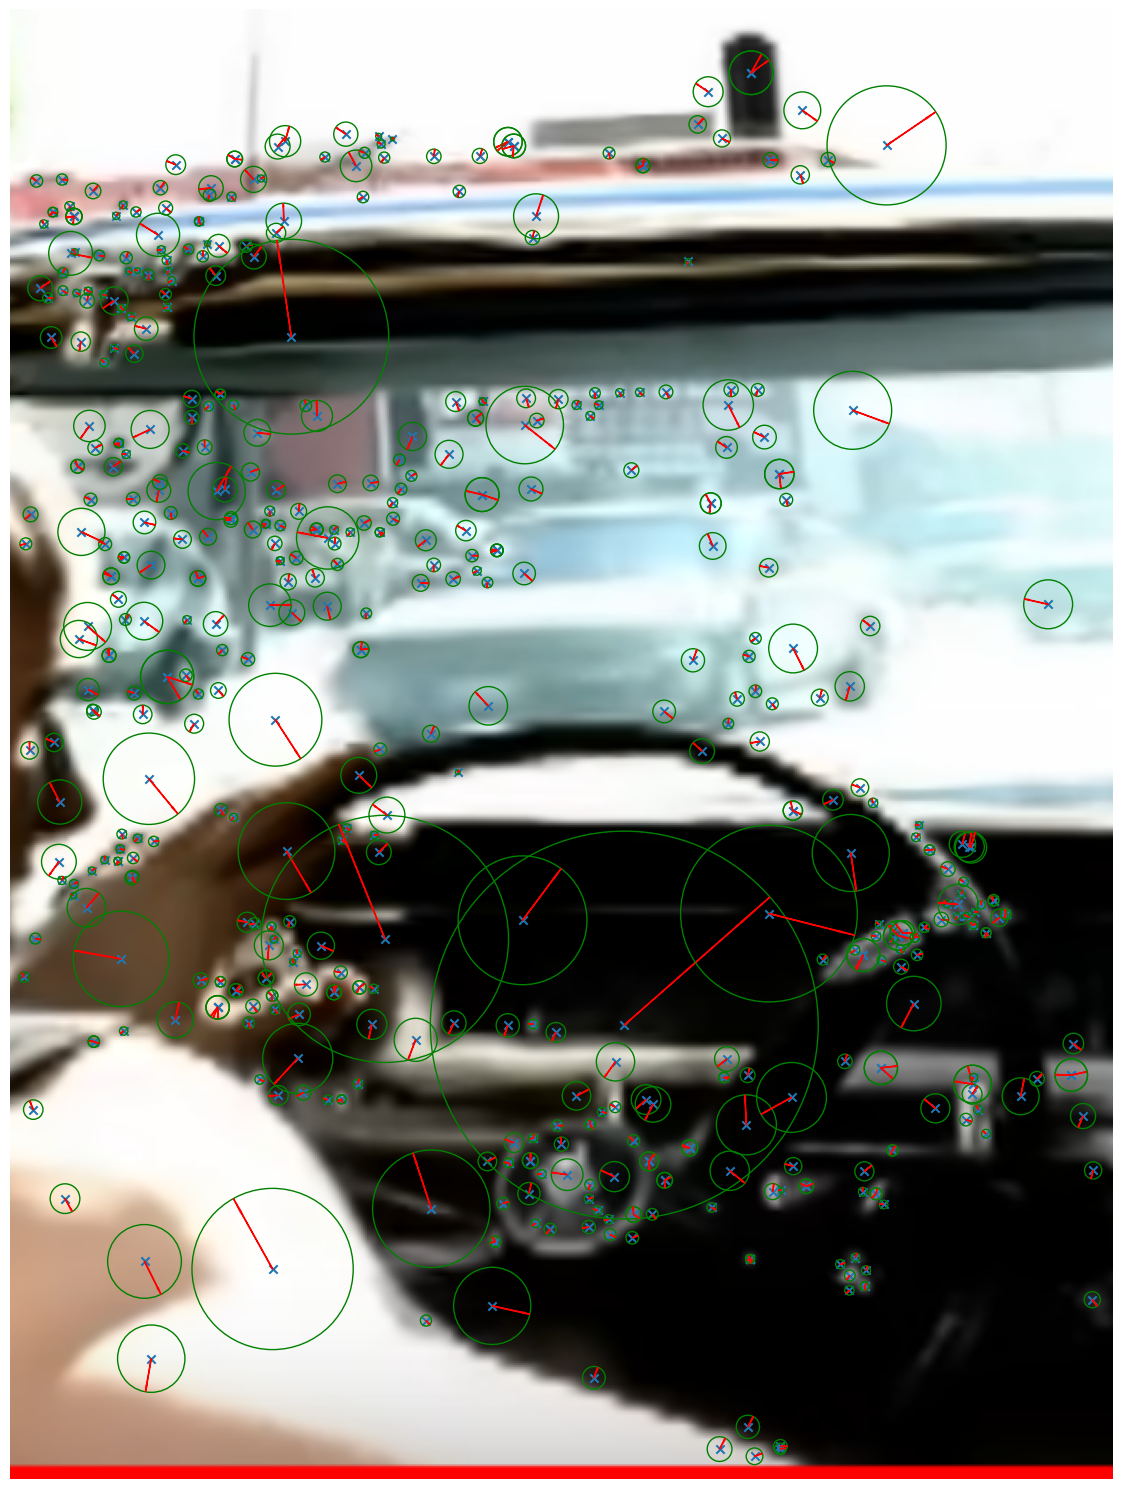

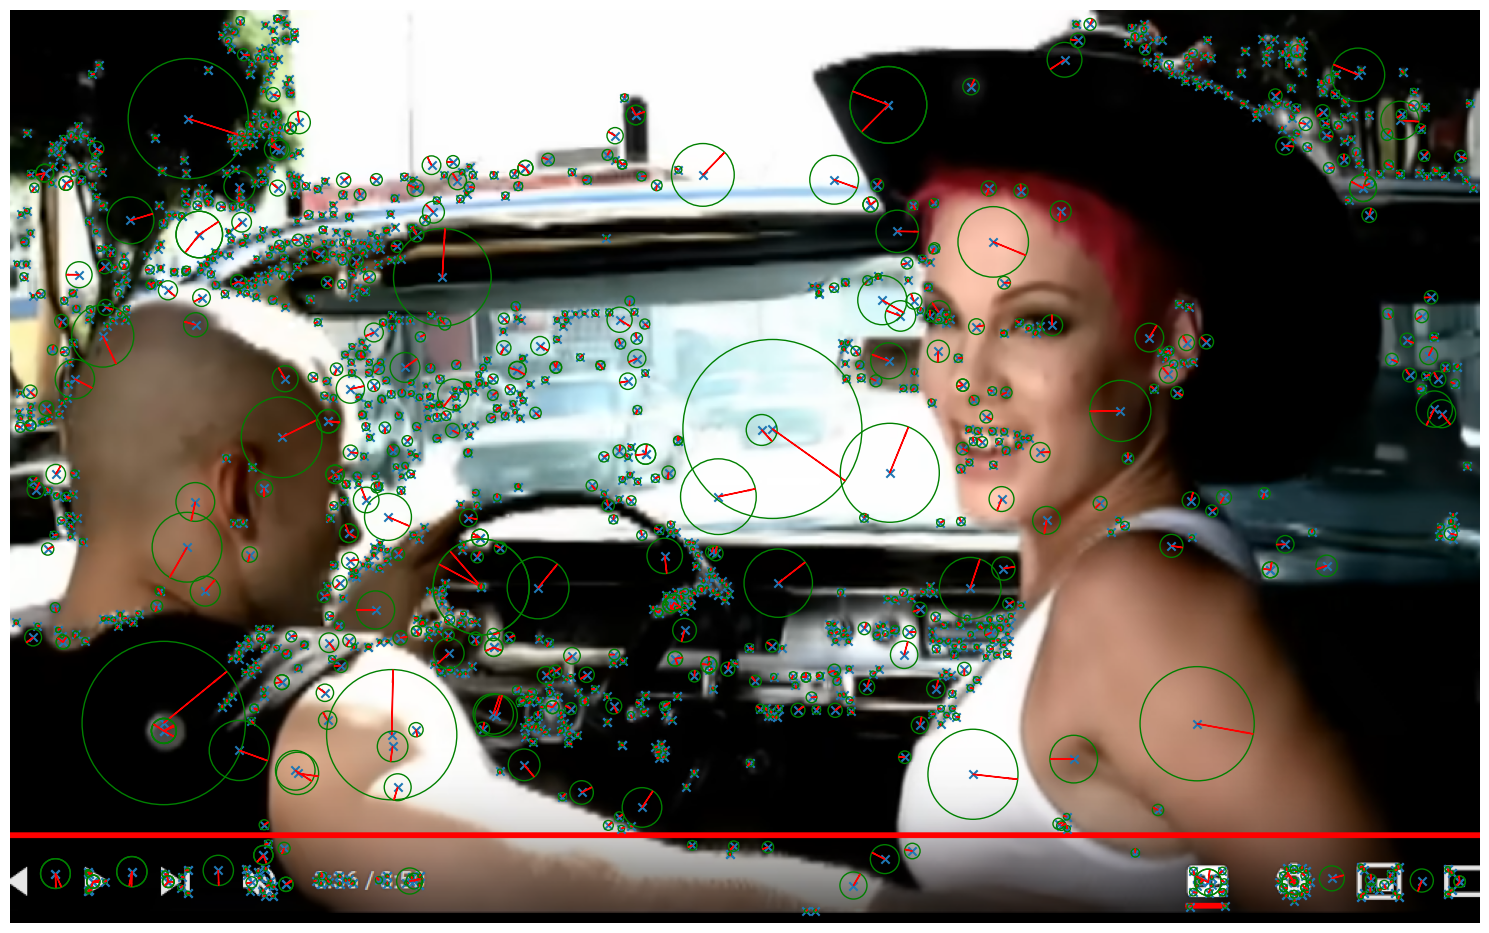

In [93]:
f = (plt.imread('jjgfff.png')[:,:,:-1]*255).astype(np.uint8)

fd = cv2.SIFT_create()
kp1, d1 = fd.detectAndCompute(GG[:,:,::-1], None)
kp2, d2 = fd.detectAndCompute(f[:,:,::-1], None)
plt.figure(figsize=(15,15))
plt.imshow(GG)
draw_keypoints(kp1)
plt.axis('off')
plt.tight_layout()
plt.figure(figsize=(15,15))
plt.imshow(f)
draw_keypoints(kp2)
plt.axis('off')
plt.tight_layout()

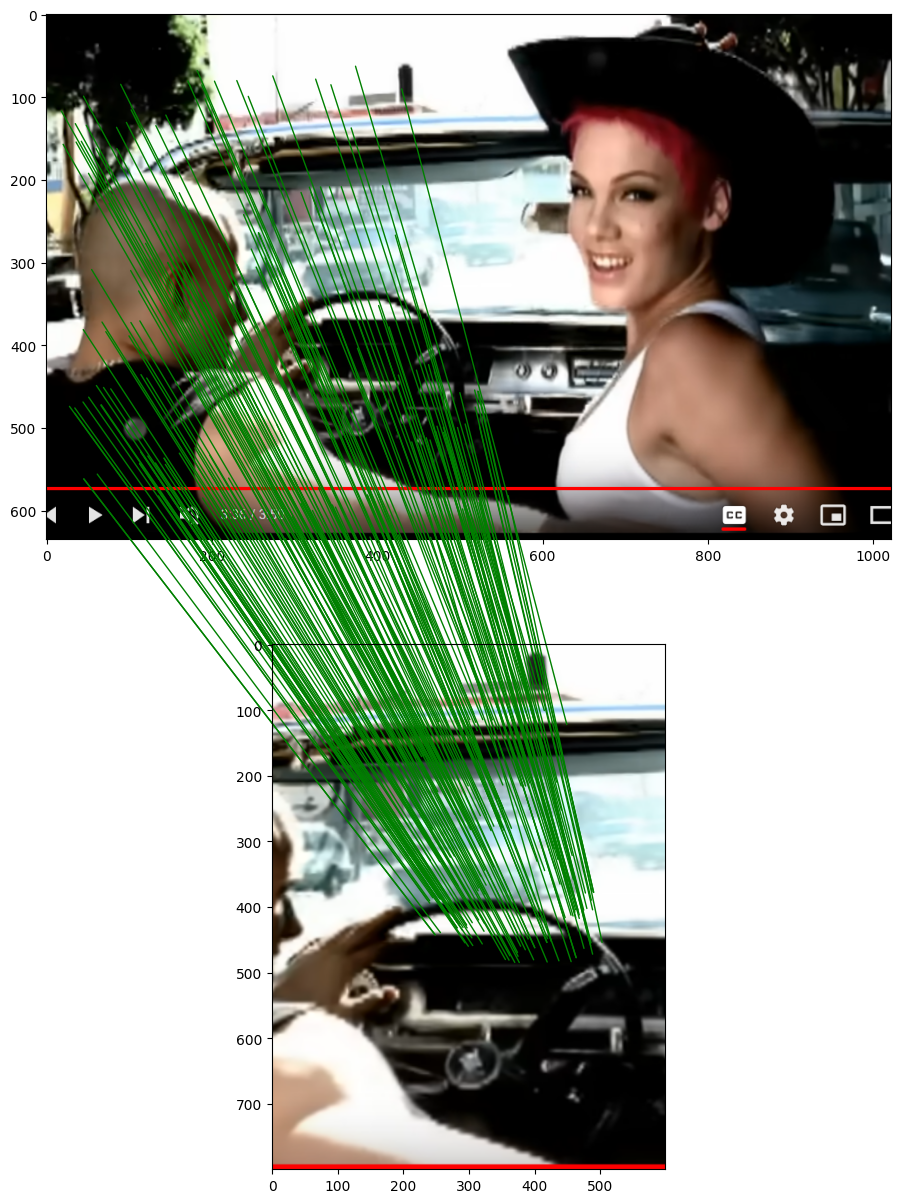

In [94]:
matcher = cv2.BFMatcher()
matches = matcher.match(d1,d2)
matches = sorted(matches, key = lambda x: x.distance)
data = [((kp1[m.queryIdx].pt), (kp2[m.trainIdx].pt)) for m in matches]
draw_matches(f, kp1, GG, kp2, matches[:200], figsize=(15,15), horizontal=False)

[[ 3.52857460e+02 -2.33706585e+01 -6.94483337e+04]
 [-5.57973777e-01  2.51764265e+02 -1.25264287e+04]
 [-1.53364401e-03 -7.75909608e-02  2.10547735e+02]]


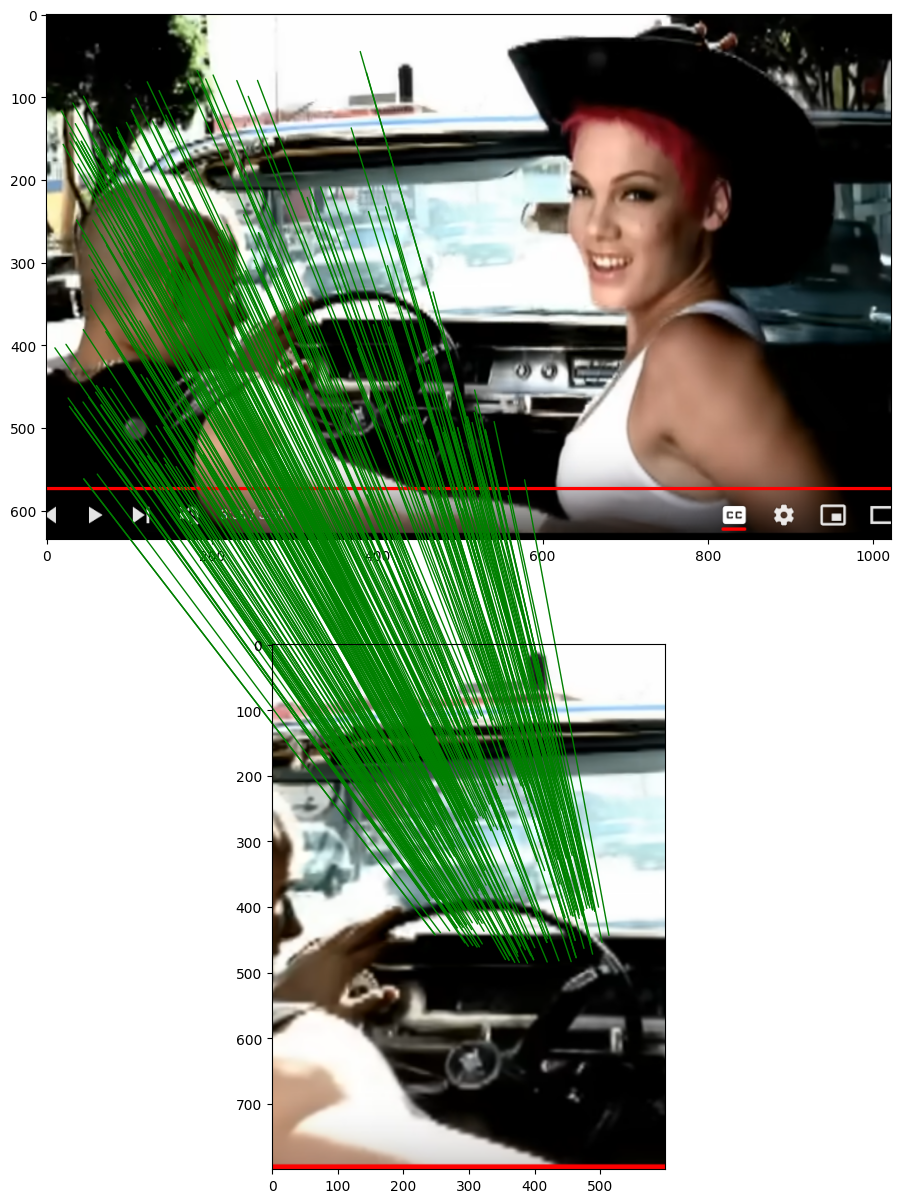

In [95]:
P, inliers = ransac(data, projective_fit_model,
                    projective_test_model, {'max_error':1}, 4, 1000)
print(np.linalg.inv(P))
draw_matches(f, kp1, GG, kp2, np.array(matches)[inliers],
             horizontal=False)

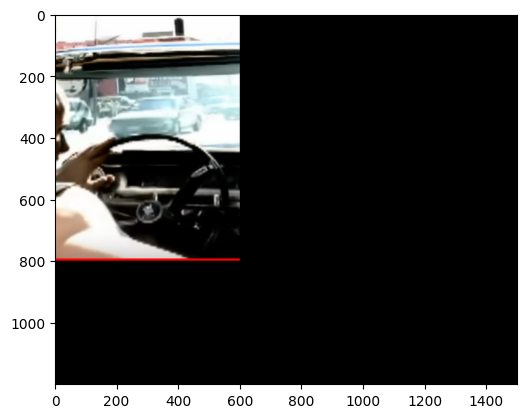

In [96]:
f_stitched=warp(GG,np.linalg.inv(P),output_shape = (1200,1500)).astype(np.uint8)

M, N = GG.shape[:2]
f_stitched[:M, :N, :] = GG
plt.imshow(f_stitched)